# Finding the Best Location to Open a Bar in Queens, NY

Import Libraries

In [1]:
import pandas as pd
import numpy as np
import json
from pandas.io.json import json_normalize
import folium
import requests 
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.cluster import KMeans

Create neighborhood dataframe

In [2]:
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

neighborhoods = pd.DataFrame(columns=column_names)

Import New York neighborhoods from json file

In [3]:
with open('nyu_2451_34572-geojson.json') as data_file:    
    newyork_data = json.load(data_file)

neighborhoods_data = newyork_data['features']

Store json information in neighborhood dataframe

In [4]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [5]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


Create Queens neighborhoods dataframe

In [6]:
queens_data = neighborhoods[neighborhoods['Borough'] == 'Queens'].reset_index(drop=True)

In [7]:
queens_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Queens,Astoria,40.768509,-73.915654
1,Queens,Woodside,40.746349,-73.901842
2,Queens,Jackson Heights,40.751981,-73.882821
3,Queens,Elmhurst,40.744049,-73.881656
4,Queens,Howard Beach,40.654225,-73.838138


In [8]:
queens_data.shape

(81, 4)

Visualize Queens map

In [9]:
# create map of Queens using latitude and longitude values
queens_map = folium.Map(location=[40.68149, -73.83652], zoom_start=11)

# add markers to map
for lat, lng, label in zip(queens_data['Latitude'], queens_data['Longitude'], queens_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(queens_map)  
    
queens_map

### 1. Finding Venues with the Help of Foursquare

In [10]:
CLIENT_ID = 'BF5VQA0V3QDQHPKOZHACLFH50T31IWNY3LK4UGIJVJWEZA3L' 
CLIENT_SECRET = 'DA0A1A4KFNYC41I2KNZTP2DJFH0KSWZB5CRO0WQAHBN3WN3C'
VERSION = '20180605'
LIMIT = 200

Get all the 200 nearby venues for each neighborhood

In [11]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Create a new dataframe with the Queens venues

In [12]:
queens_venues = getNearbyVenues(names=queens_data['Neighborhood'],
                                   latitudes=queens_data['Latitude'],
                                   longitudes=queens_data['Longitude']
                                  )

In [13]:
queens_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Astoria,40.768509,-73.915654,Favela Grill,40.767348,-73.917897,Brazilian Restaurant
1,Astoria,40.768509,-73.915654,Orange Blossom,40.769856,-73.917012,Gourmet Shop
2,Astoria,40.768509,-73.915654,Titan Foods Inc.,40.769198,-73.919253,Gourmet Shop
3,Astoria,40.768509,-73.915654,CrossFit Queens,40.769404,-73.918977,Gym
4,Astoria,40.768509,-73.915654,Simply Fit Astoria,40.769114,-73.912403,Gym


Analyze each neighborhood

In [14]:
# one hot encoding
queens_onehot = pd.get_dummies(queens_venues[['Venue Category']], prefix="", prefix_sep="")
queens_onehot.drop(['Neighborhood'], axis=1, inplace=True)
# add neighborhood column back to dataframe
queens_onehot['Neighborhood'] = queens_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [queens_onehot.columns[-1]] + list(queens_onehot.columns[:-1])
queens_onehot = queens_onehot[fixed_columns]

queens_onehot.head()

,Neighborhood,Accessories Store,Afghan Restaurant,Airport Terminal,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,...,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Weight Loss Center,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Astoria,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Astoria,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Astoria,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Astoria,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Astoria,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
queens_onehot.shape

(2154, 271)

In [16]:
queens_grouped = queens_onehot.groupby('Neighborhood').mean().reset_index()
queens_grouped

,Neighborhood,Accessories Store,Afghan Restaurant,Airport Terminal,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,...,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Weight Loss Center,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Arverne,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.058824,0.0,0.000000,0.000000
1,Astoria,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.010000,0.0,0.000000,0.000000
2,Astoria Heights,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.000000
3,Auburndale,0.000000,0.000000,0.000000,0.052632,0.000000,0.000000,0.000,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.000000
4,Bay Terrace,0.024390,0.000000,0.000000,0.048780,0.000000,0.000000,0.000,0.0,0.0,...,0.024390,0.000000,0.000000,0.0,0.02439,0.000000,0.000000,0.0,0.073171,0.000000
5,Bayside,0.000000,0.000000,0.000000,0.042254,0.000000,0.000000,0.000,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.00000,0.014085,0.000000,0.0,0.000000,0.014085
6,Bayswater,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.000000
7,Beechhurst,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.066667
8,Bellaire,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.000000
9,Belle Harbor,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.000000


Get the top 10 venue categories per neighborhood and create a new dataframe

In [17]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [18]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = queens_grouped['Neighborhood']

for ind in np.arange(queens_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(queens_grouped.iloc[ind, :], num_top_venues)

In [19]:
neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Arverne,Surf Spot,Metro Station,Coffee Shop,Board Shop,Bus Stop,Bed & Breakfast,Beach,Sandwich Place,Donut Shop,Playground
1,Astoria,Bar,Middle Eastern Restaurant,Hookah Bar,Greek Restaurant,Bakery,Seafood Restaurant,Indian Restaurant,Italian Restaurant,Gym / Fitness Center,Latin American Restaurant
2,Astoria Heights,Hostel,Gourmet Shop,Pizza Place,Deli / Bodega,Music Venue,Moving Target,Bus Station,Bus Line,Burger Joint,Plaza
3,Auburndale,Italian Restaurant,Train,Mobile Phone Shop,Furniture / Home Store,Bar,Noodle House,Supermarket,Toy / Game Store,Discount Store,Athletics & Sports
4,Bay Terrace,Clothing Store,Women's Store,Cosmetics Shop,Donut Shop,Kids Store,Lingerie Store,Mobile Phone Shop,American Restaurant,Coffee Shop,Deli / Bodega


### 2. Cluster Neighborhoods

Use K-means clustering to see which neighborhoods are related

In [20]:
# set number of clusters
kclusters = 5

queens_grouped_clustering = queens_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=42).fit(queens_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 3, 3, 3, 3, 3, 2, 3, 3, 3], dtype=int32)

Create a new dataframe with the results from the clustering analysis

In [21]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

queens_merged = queens_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
queens_merged = queens_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

queens_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Queens,Astoria,40.768509,-73.915654,3,Bar,Middle Eastern Restaurant,Hookah Bar,Greek Restaurant,Bakery,Seafood Restaurant,Indian Restaurant,Italian Restaurant,Gym / Fitness Center,Latin American Restaurant
1,Queens,Woodside,40.746349,-73.901842,3,Grocery Store,Bar,Bakery,Thai Restaurant,Latin American Restaurant,Pizza Place,Donut Shop,American Restaurant,Pub,Filipino Restaurant
2,Queens,Jackson Heights,40.751981,-73.882821,3,Latin American Restaurant,South American Restaurant,Peruvian Restaurant,Bakery,Mobile Phone Shop,Thai Restaurant,Spanish Restaurant,Shoe Store,Mexican Restaurant,Diner
3,Queens,Elmhurst,40.744049,-73.881656,3,Thai Restaurant,Mexican Restaurant,Bubble Tea Shop,Chinese Restaurant,South American Restaurant,Vietnamese Restaurant,Indonesian Restaurant,Hotpot Restaurant,Snack Place,Food
4,Queens,Howard Beach,40.654225,-73.838138,3,Bagel Shop,Italian Restaurant,Sandwich Place,Pharmacy,Spa,Deli / Bodega,Clothing Store,Gym,Fast Food Restaurant,Shipping Store


Create a new map of Queens with the clustering results

In [22]:
# create map
map_clusters = folium.Map(location=[40.68149, -73.83652], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(queens_merged['Latitude'], queens_merged['Longitude'], queens_merged['Neighborhood'], queens_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### 3. Analyze Each Cluster

In order to find the neighborhood to open a bar, we can analyze each cluster and see which clusters don't have bar as a top venue

In [23]:
def get_total_venues_per_cluster(cluster_no):
    # Count all the venues across all the neighborhoods in the cluster
    cls = queens_merged.loc[queens_merged['Cluster Labels'] == cluster_no, queens_merged.columns[[1] + list(range(5, queens_merged.shape[1]))]]
    count = pd.Series(cls.loc[:, cls.columns != 'Neighborhood'].squeeze().values.ravel()).value_counts()
    ct = pd.DataFrame({'Venue': count.index, 'Count':count.values, 'Percentage':(count/count.sum()).values})
    # Create bar char 
    %matplotlib inline
    ct[:20].plot.barh(x='Venue',y='Count',figsize=(10,7),legend='')
    plt.title('Cluster {0} Top Venues'.format(cluster_no))
    plt.show()

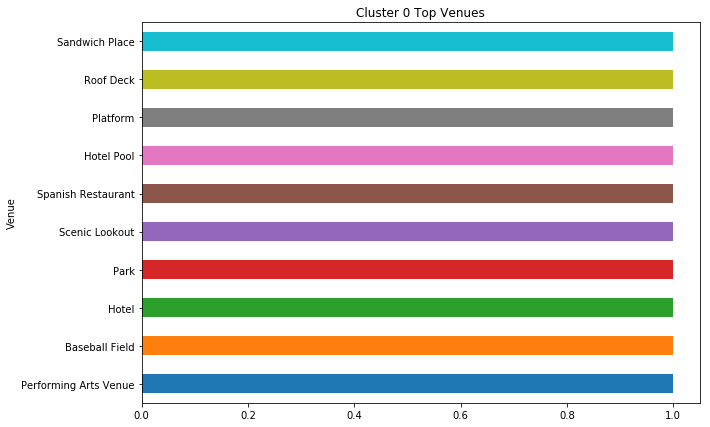

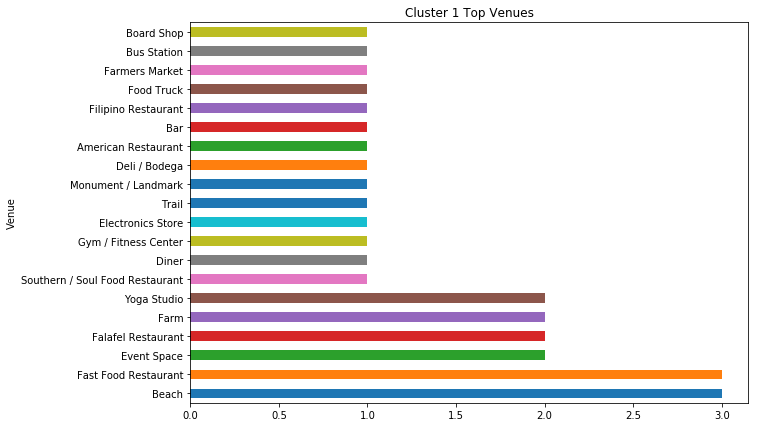

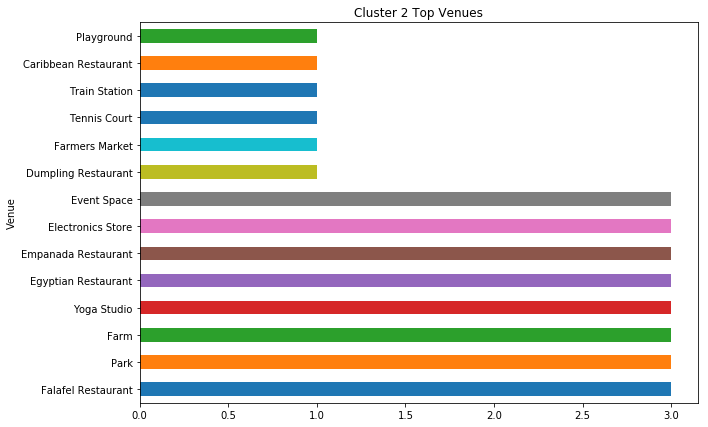

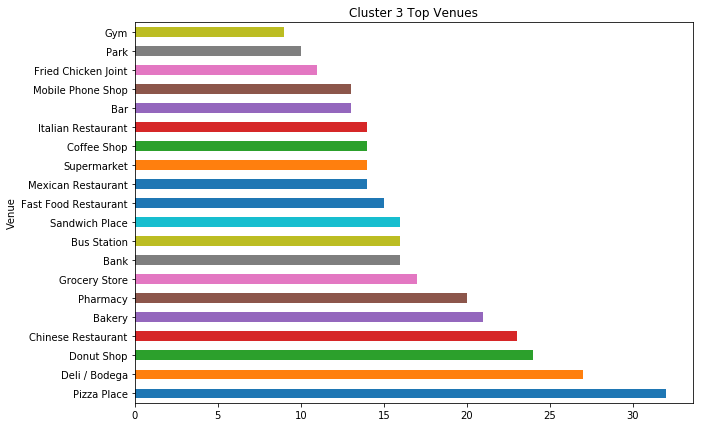

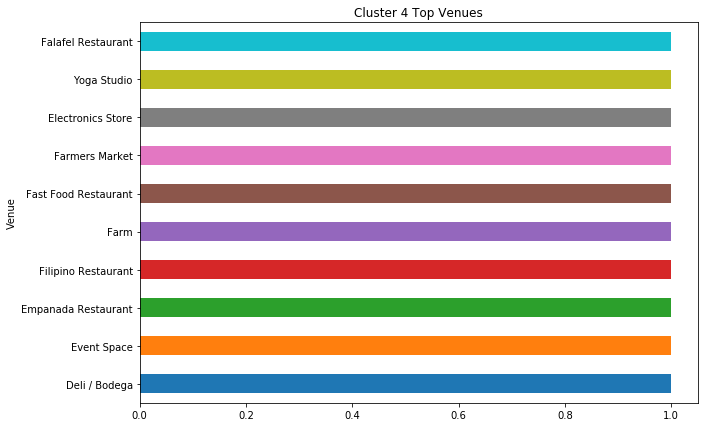

In [24]:
for x in range(0,5):
    get_total_venues_per_cluster(x)

Based on the graphs, cluster 1 and cluster 3 have "bar" as a top venue. As a result, We can discard the neighborhoods in these two clusters

We can create the final dataframe by excluding the neighborhoods in cluster 1 and 3

In [25]:
queens_results = queens_merged[~queens_merged['Cluster Labels'].isin([1,3])].reset_index(drop=True)
queens_results

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Queens,Laurelton,40.667884,-73.740256,2,Caribbean Restaurant,Park,Train Station,Yoga Studio,Egyptian Restaurant,Electronics Store,Empanada Restaurant,Event Space,Falafel Restaurant,Farm
1,Queens,Somerville,40.597711,-73.796648,2,Park,Yoga Studio,Farm,Egyptian Restaurant,Electronics Store,Empanada Restaurant,Event Space,Falafel Restaurant,Farmers Market,Dumpling Restaurant
2,Queens,Brookville,40.660003,-73.751753,4,Deli / Bodega,Yoga Studio,Fast Food Restaurant,Electronics Store,Empanada Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Filipino Restaurant
3,Queens,Bayswater,40.611322,-73.765968,2,Tennis Court,Playground,Park,Yoga Studio,Falafel Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,Event Space,Farm
4,Queens,Queensbridge,40.756091,-73.945631,0,Hotel,Sandwich Place,Performing Arts Venue,Baseball Field,Scenic Lookout,Spanish Restaurant,Roof Deck,Park,Platform,Hotel Pool


### 4. Conclusion

Based on the clustering analysis, Laurelton, Somerville, Brookville, Bayswater and Queensbridge seem to be the best locations to open a bar in Queens, NY

In [26]:
# create map of Queens using latitude and longitude values
queens_map = folium.Map(location=[40.68149, -73.83652], zoom_start=11)

# add markers to map
for lat, lng, label in zip(queens_results['Latitude'], queens_results['Longitude'], queens_results['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.Marker(
        [lat, lng],
        popup=label
        ).add_to(queens_map) 
    
queens_map